# To cluster images based on visual similarity

In [2]:
#importing libraries

import numpy as np
import pandas as pd
import os
import re
import pickle
from random import randint
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from keras.applications.vgg16 import VGG16
from keras.models import Model

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input

In [9]:
img_names = []
path = '/content/drive/MyDrive/Datasets/Flower Images/flower_images'
with os.scandir(path) as files:
  for filename in files:
    if filename.name.endswith('.png'):
      img_names.append(filename.name)

img_names[:10]

['0144.png',
 '0208.png',
 '0103.png',
 '0058.png',
 '0147.png',
 '0005.png',
 '0173.png',
 '0138.png',
 '0003.png',
 '0157.png']

In [10]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [13]:
def feature_extract(file, model):
  img = load_img(path+'/'+file, target_size=(224,224))
  img = np.array(img)
  reshaped_img = img.reshape(1,224,224,3)
  imgx = preprocess_input(reshaped_img)
  feature = model.predict(imgx, use_multiprocessing = True)
  return feature

data = {}

for img in img_names:
  feature = feature_extract(img, model)
  data[img] = feature

In [14]:
data

{'0001.png': array([[1.7499069, 0.       , 0.       , ..., 1.4705435, 0.       ,
         0.       ]], dtype=float32),
 '0002.png': array([[1.5184731, 0.       , 0.       , ..., 1.3963168, 0.       ,
         0.       ]], dtype=float32),
 '0003.png': array([[0.       , 0.       , 0.       , ..., 1.6420488, 0.       ,
         0.       ]], dtype=float32),
 '0004.png': array([[0.31190795, 0.        , 0.        , ..., 5.80999   , 0.        ,
         0.        ]], dtype=float32),
 '0005.png': array([[1.1722385, 0.       , 0.       , ..., 3.0004776, 0.       ,
         0.       ]], dtype=float32),
 '0006.png': array([[0.729362, 0.      , 0.      , ..., 0.      , 0.      , 0.      ]],
       dtype=float32),
 '0007.png': array([[0.       , 0.       , 0.       , ..., 2.3083327, 0.       ,
         0.       ]], dtype=float32),
 '0008.png': array([[0.      , 0.      , 0.      , ..., 2.870494, 0.      , 0.      ]],
       dtype=float32),
 '0009.png': array([[0.        , 0.        , 0.        , .

In [16]:
img_filenames = np.array(list(data.keys()))
img_features = np.array(list(data.values()))

array([[[0.        , 0.        , 0.        , ..., 1.6898623 ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 4.192659  ,
         0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        , ..., 0.25967383,
         1.6816547 , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 1.4941809 ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)

In [18]:
img_features = img_features.reshape(-1, 4096)

In [20]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Flower Images/flower_images/flower_labels.csv')
labels = df['label'].tolist()
unique_labels = list(set(labels))
unique_labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

We have a total of 10 labels, hence we will use a clustering with 10 clusters

In [24]:
pca = PCA(n_components = 150, random_state=42)
pca.fit(img_features)
x = pca.transform(img_features)

array([[ 1.6005787e+01,  3.5690472e+01,  1.0219275e+01, ...,
        -1.9411944e+00,  7.2964615e-01, -1.1581406e-01],
       [ 5.1748966e+01, -5.3677802e+00, -1.0770574e+01, ...,
         1.2864562e+00,  3.0110255e-02,  5.3065920e-01],
       [ 7.2661682e+01,  2.6122878e+00, -1.5117763e+01, ...,
        -1.1110519e+00,  9.9812254e-02, -1.4964489e+00],
       ...,
       [-4.8936982e+00,  3.6709480e+01,  1.0282402e+01, ...,
        -8.2040757e-01, -7.3616898e-01,  1.2061458e+00],
       [-1.4282582e+01, -1.0573522e+01,  3.5610519e+01, ...,
         1.4118603e-01, -5.4969198e-01,  2.1595877e-01],
       [ 6.5269156e+00, -1.0533096e+01, -1.1503962e+01, ...,
        -2.8356215e-01,  7.7267218e-01, -1.4591731e+00]], dtype=float32)

In [27]:
kmeans = KMeans(n_clusters = len(unique_labels), random_state=42)
kmeans.fit(x)

KMeans(n_clusters=10, random_state=42)

In [34]:
print(img_filenames.shape)
print(kmeans.labels_.shape)

(210,)
(210,)


In [35]:
groups = {}

for filename, cluster in zip(img_filenames, kmeans.labels_):
  if cluster not in groups.keys():
    groups[cluster] = []
    groups[cluster].append(filename)
  else:
    groups[cluster].append(filename)


## Clustering was successful and we can view the clustered data

In [37]:
# groups

In [45]:
#we will now see how the data is clustered
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    
    files = groups[cluster]
    
    if len(files) > 10:
        print(f"Clipping cluster size from {len(files)} to 10")
        files = files[:9]

    print("Cluster : "+str(cluster+1))

    for index, filename in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(path+'/'+filename)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Clipping cluster size from 17 to 10
Cluster : 1


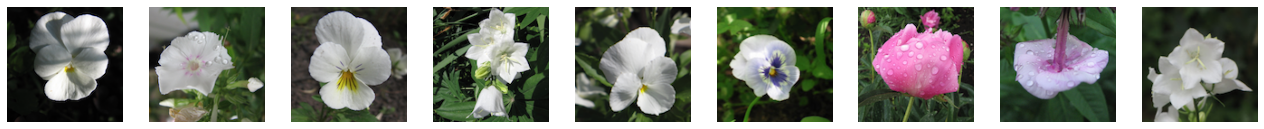

In [46]:
view_cluster(0)

Clipping cluster size from 32 to 10
Cluster : 2


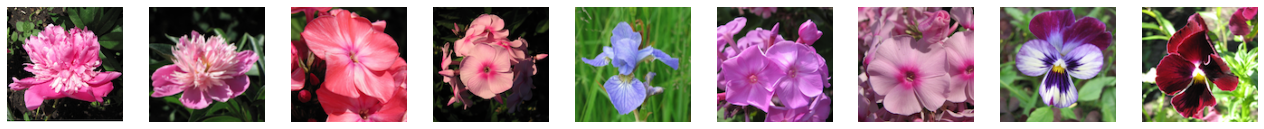

In [47]:
view_cluster(1)

Clipping cluster size from 20 to 10
Cluster : 3


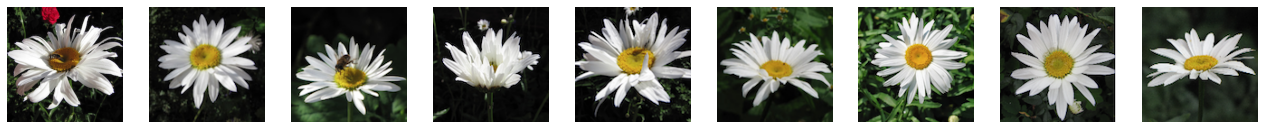

In [48]:
view_cluster(2)

Clipping cluster size from 35 to 10
Cluster : 4


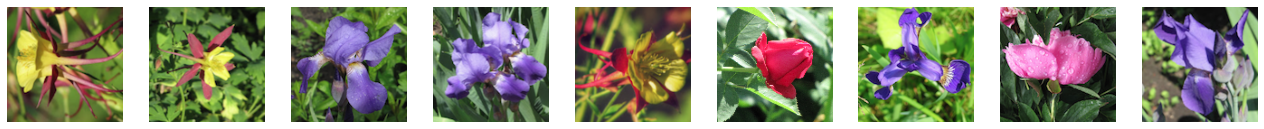

In [49]:
view_cluster(3)

Clipping cluster size from 17 to 10
Cluster : 1
Clipping cluster size from 32 to 10
Cluster : 2
Clipping cluster size from 20 to 10
Cluster : 3
Clipping cluster size from 35 to 10
Cluster : 4
Cluster : 5
Clipping cluster size from 19 to 10
Cluster : 6
Clipping cluster size from 18 to 10
Cluster : 7
Clipping cluster size from 20 to 10
Cluster : 8
Clipping cluster size from 16 to 10
Cluster : 9
Clipping cluster size from 24 to 10
Cluster : 10


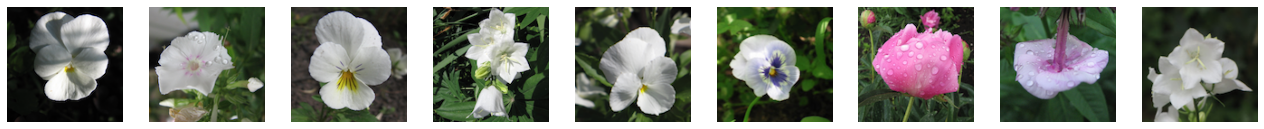

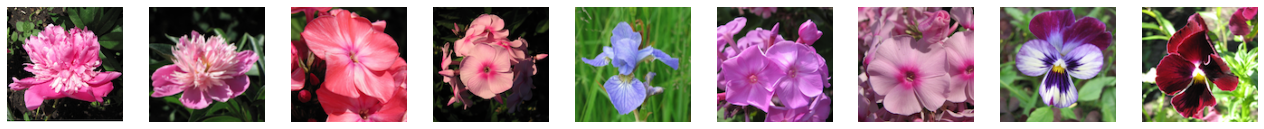

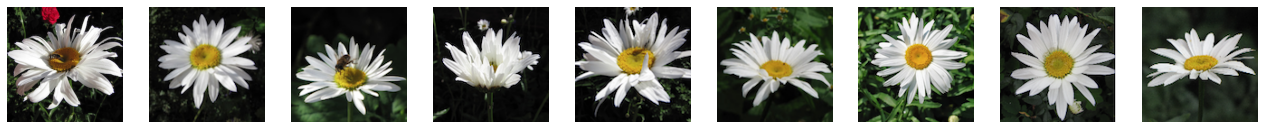

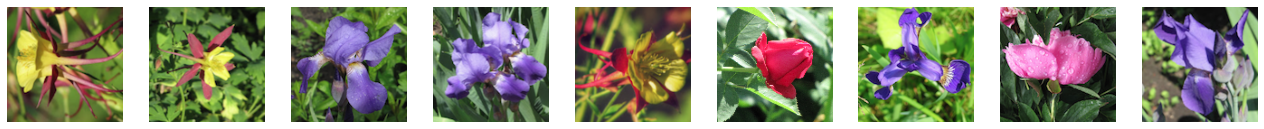

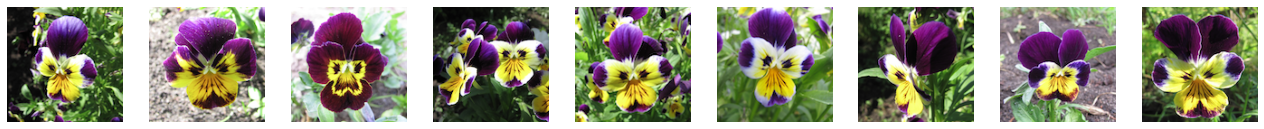

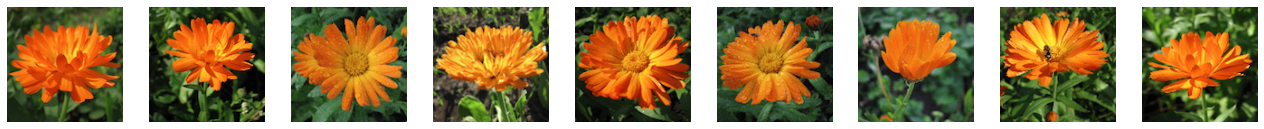

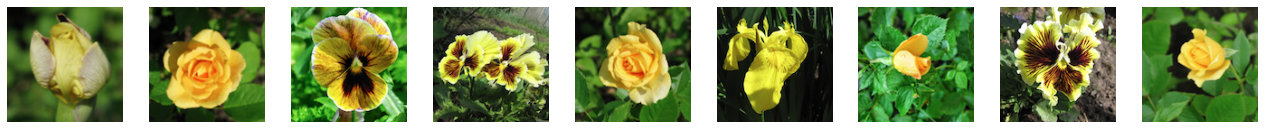

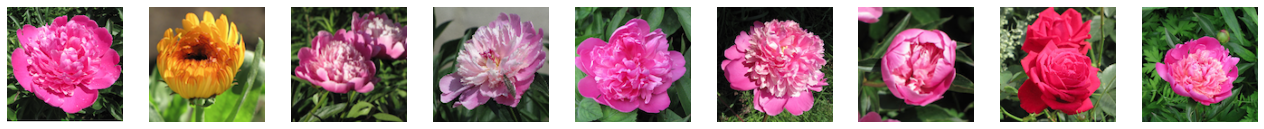

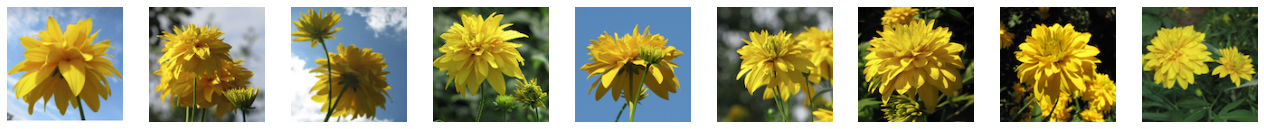

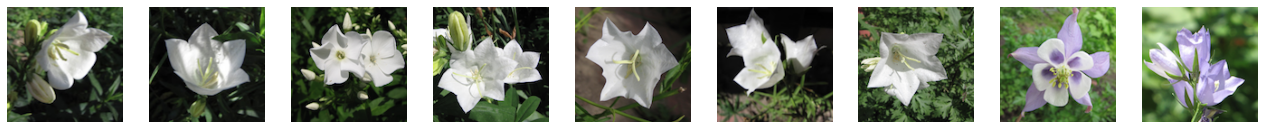

In [50]:
# different clusters on different lines
for i in range(10):
  view_cluster(i)

checking the best clustering parameter for flowers

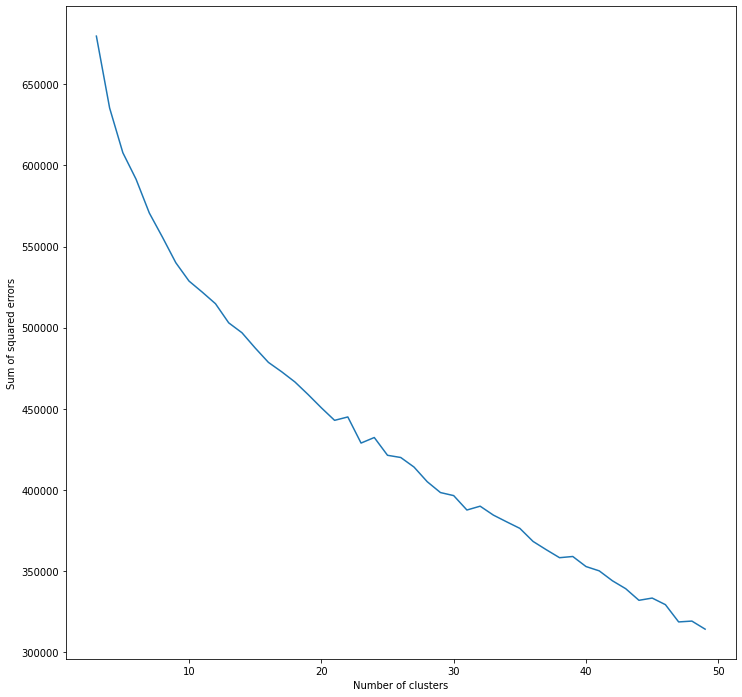

In [56]:
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(12, 12))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters')
plt.ylabel('Sum of squared errors');